**Pre-Processing**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
import os
import time

Reading Dataset

In [2]:
df=[]
for i in range(1,5):
  path='/content/sample_data/UNSW-NB15_{}.csv'
  df.append(pd.read_csv(path.format(i), header=None))
data = pd.concat(df).reset_index(drop=True)
data.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2540047, 49)

In [3]:
data_feat = pd.read_csv('/content/sample_data/NUSW-NB15_features.csv', encoding='ISO-8859-1')
data_feat['Name'] = data_feat['Name'].apply(lambda x: x.strip().replace(' ', '').lower())
data.columns = data_feat['Name']
data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.93750,621800.93750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.08594,50480.17188,4,4,0,0,0,0,132,76,0,0,9.89101,10.682733,1421927414,1421927414,7.005,7.564333,0.0,0.0,0.0,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.53130,636282.37500,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.017,0.013000,0.0,0.0,0.0,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.56250,542597.18750,2,2,0,0,0,0,66,82,0,0,0.00000,0.000000,1421927414,1421927414,0.043,0.014000,0.0,0.0,0.0,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.25000,609067.56250,2,2,0,0,0,0,73,89,0,0,0.00000,0.000000,1421927414,1421927414,0.005,0.003000,0.0,0.0,0.0,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0


In [4]:
train, test = train_test_split(data, test_size=0.3, random_state=0)
train.shape

(1778032, 49)

In [5]:
test.shape

(762015, 49)

In [6]:
train.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,ltime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
262209,59.166.0.3,28756,149.171.126.0,26811,tcp,FIN,0.029975,4014,57836,31,29,7,28,-,1.055546e+06,1.521535e+07,68,70,255,255,208235019,2373132436,59,826,0,0,0.000000,23.540364,1421937769,1421937769,0.442597,0.426304,0.000695,0.000556,0.000139,0,0,0.0,0.0,0,8,4,1,2,1,1,1,NaN,0
225020,59.166.0.3,2037,149.171.126.0,10596,tcp,FIN,0.010853,2230,13288,31,29,7,11,-,1.595872e+06,9.522897e+06,34,36,255,255,487867095,2637725120,66,369,0,0,22.672907,21.542192,1421936048,1421936048,0.319697,0.294771,0.000653,0.000529,0.000124,0,0,0.0,0.0,0,11,3,4,5,1,1,2,NaN,0
1802864,59.166.0.9,10851,149.171.126.5,80,tcp,FIN,1.094710,1684,10168,31,29,3,5,http,1.142951e+04,7.018480e+04,14,18,255,255,536716439,2687376793,120,565,0,0,8797.576648,7703.519992,1424241707,1424241708,84.182154,64.361529,0.000721,0.000560,0.000161,0,0,NaN,NaN,,2,1,4,3,1,1,4,NaN,0
919097,59.166.0.4,51060,149.171.126.6,25483,tcp,FIN,0.021920,2558,23268,31,29,7,14,-,9.105840e+05,8.289782e+06,40,42,255,255,3496437099,1347167990,64,554,0,0,35.582433,34.630980,1421965378,1421965378,0.553359,0.532800,0.000743,0.000598,0.000145,0,0,0.0,0.0,0,9,7,3,2,1,1,1,NaN,0
1401105,59.166.0.6,39371,149.171.126.1,80,tcp,FIN,1.034522,1580,10168,31,29,3,5,http,1.120517e+04,7.426811e+04,12,18,255,255,683548608,2834137940,132,565,1,3924,9598.045575,7776.927343,1424231163,1424231164,94.015000,60.825767,0.000597,0.000479,0.000118,0,0,1.0,NaN,,2,2,1,4,1,1,1,NaN,0


Cleaning Dataset

*Finding null values and filling them*

In [7]:
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [8]:
train['attack_cat'].value_counts()

Generic             150587
Exploits             31185
 Fuzzers             13476
DoS                  11358
 Reconnaissance       8608
 Fuzzers              3583
Analysis              1865
Reconnaissance        1254
Backdoor              1239
 Shellcode             920
Backdoors              380
Shellcode              148
Worms                  123
Name: attack_cat, dtype: int64

In [9]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)
train['attack_cat'] = train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [10]:
train.isnull().sum().sum()

0

Datatype Information

In [11]:
train.dtypes.value_counts()

int64      29
float64    11
object      9
dtype: int64

In [12]:
train['ct_ftp_cmd'].unique()
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Finding Correlation and removing highly correlated data

In [13]:
normal = train[train['label']==0]
anomaly = train[train['label']==1]

In [14]:
def corr(col1, col2="label", df=train):
    return df[[col1, col2]].corr().iloc[0,1]

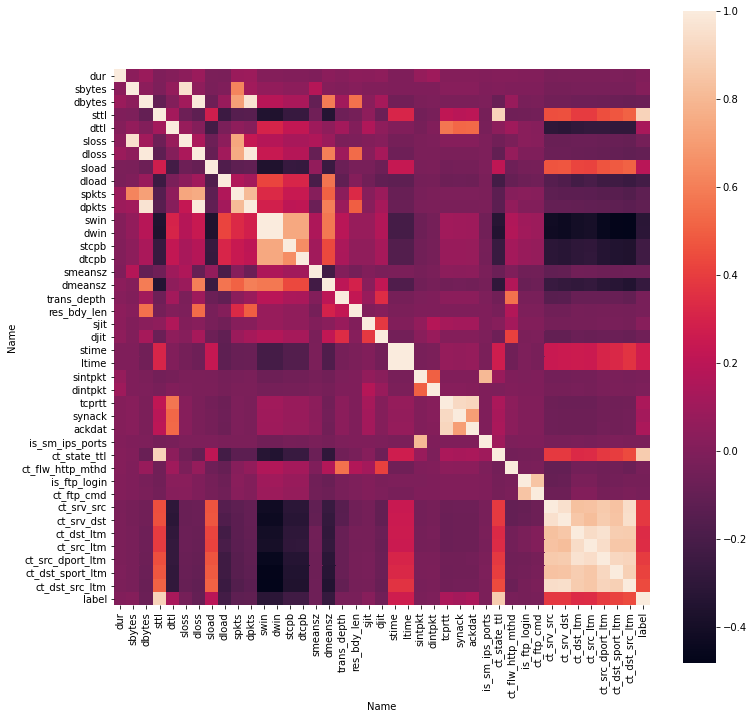

In [15]:
corr_mat = train.corr(method="pearson")
plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [16]:
limit = 0.9
columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

sbytes               sloss                0.9581285657722225
dbytes               dloss                0.9913325160849764
dbytes               dpkts                0.9706236361113262
sttl                 ct_state_ttl         0.905930209639797
sttl                 label                0.9044318112514584
dloss                dpkts                0.9919988285848562
swin                 dwin                 0.9971600128201086
stime                ltime                0.9999999997899374
tcprtt               synack               0.9297911269387318
tcprtt               ackdat               0.9185516458838555
ct_srv_src           ct_srv_dst           0.9567993915222623
ct_srv_src           ct_dst_src_ltm       0.9422207389782216
ct_srv_dst           ct_dst_src_ltm       0.9510651409828361
ct_dst_ltm           ct_src_ltm           0.9385972062207393
ct_dst_ltm           ct_src_dport_ltm     0.9602537526221788
ct_src_ltm           ct_src_dport_ltm     0.9452983773355971
ct_src_dport_ltm     ct_d

In [17]:
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_src_ltm']


In [18]:
train.drop(columns=to_drop, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Removing useless columns

In [19]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
train.drop(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
train.head()

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,service,sload,dload,spkts,swin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_dst_sport_ltm,label,network_bytes
262209,tcp,FIN,0.029975,4014,57836,31,29,-,1.055546e+06,1.521535e+07,68,255,208235019,2373132436,59,826,0,0,0.000000,23.540364,1421937769,0.442597,0.426304,0.000695,0.000556,0.000139,0,0,0.0,0,0,8,1,2,1,0,61850
225020,tcp,FIN,0.010853,2230,13288,31,29,-,1.595872e+06,9.522897e+06,34,255,487867095,2637725120,66,369,0,0,22.672907,21.542192,1421936048,0.319697,0.294771,0.000653,0.000529,0.000124,0,0,0.0,0,0,11,4,5,1,0,15518
1802864,tcp,FIN,1.094710,1684,10168,31,29,http,1.142951e+04,7.018480e+04,14,255,536716439,2687376793,120,565,0,0,8797.576648,7703.519992,1424241707,84.182154,64.361529,0.000721,0.000560,0.000161,0,0,0.0,0,0,2,4,3,1,0,11852
919097,tcp,FIN,0.021920,2558,23268,31,29,-,9.105840e+05,8.289782e+06,40,255,3496437099,1347167990,64,554,0,0,35.582433,34.630980,1421965378,0.553359,0.532800,0.000743,0.000598,0.000145,0,0,0.0,0,0,9,3,2,1,0,25826
1401105,tcp,FIN,1.034522,1580,10168,31,29,http,1.120517e+04,7.426811e+04,12,255,683548608,2834137940,132,565,1,3924,9598.045575,7776.927343,1424231163,94.015000,60.825767,0.000597,0.000479,0.000118,0,0,1.0,0,0,2,1,4,1,0,11748


In [22]:
train.shape, test.shape

((1778032, 37), (762015, 49))

Standardizing

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1778032 entries, 262209 to 305711
Data columns (total 37 columns):
 #   Column            Dtype  
---  ------            -----  
 0   proto             object 
 1   state             object 
 2   dur               float64
 3   sbytes            int64  
 4   dbytes            int64  
 5   sttl              int64  
 6   dttl              int64  
 7   service           object 
 8   sload             float64
 9   dload             float64
 10  spkts             int64  
 11  swin              int64  
 12  stcpb             int64  
 13  dtcpb             int64  
 14  smeansz           int64  
 15  dmeansz           int64  
 16  trans_depth       int64  
 17  res_bdy_len       int64  
 18  sjit              float64
 19  djit              float64
 20  stime             int64  
 21  sintpkt           float64
 22  dintpkt           float64
 23  tcprtt            float64
 24  synack            float64
 25  ackdat            float64
 26  is_sm_ips_

In [24]:
X_train, Y_train = train.drop(columns=['label']), train['label']
X_test, Y_test = test.drop(columns=['label']), test['label']
print(X_train.shape, Y_train.shape)
print()
print(X_test.shape, Y_test.shape)

(1778032, 36) (1778032,)

(762015, 48) (762015,)


In [25]:
cat_col = ['proto', 'service', 'state']
num_col = list(set(X_train.columns) - set(cat_col))

In [26]:
scaler = StandardScaler()
scaler = scaler.fit(X_train[num_col])
X_train[num_col] = scaler.transform(X_train[num_col])
X_train.head()

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,service,sload,dload,spkts,swin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_dst_sport_ltm,network_bytes
262209,tcp,FIN,-0.046140,-0.006270,0.132535,-0.425783,-0.041305,-,-0.302124,3.019628,0.445717,0.836302,-0.740593,0.781429,-0.429488,1.635754,-0.230249,-0.089048,-0.093240,-0.207167,-1.166419,-0.069432,-0.054834,-0.120100,-0.106629,-0.115731,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.111230,-0.666231,-0.597361,-0.419784,0.120338
225020,tcp,FIN,-0.047545,-0.036115,-0.144060,-0.425783,-0.041305,-,-0.297580,1.672873,0.008467,0.836302,-0.543891,0.967480,-0.383469,0.274769,-0.230249,-0.089048,-0.091917,-0.207753,-1.167936,-0.069476,-0.054926,-0.121023,-0.107687,-0.116362,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,0.165597,-0.298814,-0.231895,-0.419784,-0.145527
1802864,tcp,FIN,0.032112,-0.045249,-0.163432,-0.425783,-0.041305,http,-0.310905,-0.563508,-0.248738,0.836302,-0.509529,1.002393,-0.028465,0.858474,-0.230249,-0.089048,0.420044,2.046140,0.864520,-0.039328,-0.010124,-0.119529,-0.106472,-0.114805,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.664883,-0.298814,-0.475539,-0.419784,-0.166563
919097,tcp,FIN,-0.046732,-0.030628,-0.082095,-0.425783,-0.041305,-,-0.303343,1.381135,0.085629,0.836302,1.572426,0.060013,-0.396617,0.825715,-0.230249,-0.089048,-0.091164,-0.203913,-1.142081,-0.069392,-0.054760,-0.119046,-0.104982,-0.115478,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.018955,-0.421286,-0.597361,-0.419784,-0.086377
1401105,tcp,FIN,0.027688,-0.046989,-0.163432,-0.425783,-0.041305,http,-0.310907,-0.562542,-0.274459,0.836302,-0.406243,1.105590,0.050425,0.858474,2.534910,-0.006863,0.466746,2.067678,0.855226,-0.035793,-0.012596,-0.122252,-0.109647,-0.116615,-0.04078,-0.38207,1.609285,-0.129755,-0.11121,-0.664883,-0.666231,-0.353717,-0.419784,-0.167160


Modifying Categorical data

In [27]:
X_train.drop('proto', axis = 1, inplace = True)
X_train.drop('state', axis = 1, inplace = True)
X_train.drop('service', axis = 1, inplace = True)

In [28]:
X_train.head()

Name,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,swin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_dst_sport_ltm,network_bytes
262209,-0.046140,-0.006270,0.132535,-0.425783,-0.041305,-0.302124,3.019628,0.445717,0.836302,-0.740593,0.781429,-0.429488,1.635754,-0.230249,-0.089048,-0.093240,-0.207167,-1.166419,-0.069432,-0.054834,-0.120100,-0.106629,-0.115731,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.111230,-0.666231,-0.597361,-0.419784,0.120338
225020,-0.047545,-0.036115,-0.144060,-0.425783,-0.041305,-0.297580,1.672873,0.008467,0.836302,-0.543891,0.967480,-0.383469,0.274769,-0.230249,-0.089048,-0.091917,-0.207753,-1.167936,-0.069476,-0.054926,-0.121023,-0.107687,-0.116362,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,0.165597,-0.298814,-0.231895,-0.419784,-0.145527
1802864,0.032112,-0.045249,-0.163432,-0.425783,-0.041305,-0.310905,-0.563508,-0.248738,0.836302,-0.509529,1.002393,-0.028465,0.858474,-0.230249,-0.089048,0.420044,2.046140,0.864520,-0.039328,-0.010124,-0.119529,-0.106472,-0.114805,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.664883,-0.298814,-0.475539,-0.419784,-0.166563
919097,-0.046732,-0.030628,-0.082095,-0.425783,-0.041305,-0.303343,1.381135,0.085629,0.836302,1.572426,0.060013,-0.396617,0.825715,-0.230249,-0.089048,-0.091164,-0.203913,-1.142081,-0.069392,-0.054760,-0.119046,-0.104982,-0.115478,-0.04078,-0.38207,-0.198510,-0.129755,-0.11121,-0.018955,-0.421286,-0.597361,-0.419784,-0.086377
1401105,0.027688,-0.046989,-0.163432,-0.425783,-0.041305,-0.310907,-0.562542,-0.274459,0.836302,-0.406243,1.105590,0.050425,0.858474,2.534910,-0.006863,0.466746,2.067678,0.855226,-0.035793,-0.012596,-0.122252,-0.109647,-0.116615,-0.04078,-0.38207,1.609285,-0.129755,-0.11121,-0.664883,-0.666231,-0.353717,-0.419784,-0.167160


In [29]:
X_train.shape

(1778032, 33)

In [30]:
X_test.reset_index(drop=True, inplace=True)

In [31]:
X_test['network_bytes'] = X_test['dbytes'] + X_test['sbytes']
X_test.drop(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], axis=1, inplace=True)
X_test.drop(columns=to_drop, inplace=True)
X_test.drop('proto', axis = 1, inplace = True)
X_test.drop('state', axis = 1, inplace = True)
X_test.drop('service', axis = 1, inplace = True)

In [32]:
for col in X_test.columns:
  X_test[col] = X_test[col].fillna(value=0)
  X_test[col] = X_test[col].replace(' ', value=0)
  X_test[col] = X_test[col].apply(lambda x:"None" if x=="-" else x)

In [33]:
X_test.head()

Name,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,swin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,sjit,djit,stime,sintpkt,dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_dst_ltm,ct_src_ltm,ct_dst_sport_ltm,network_bytes
0,0.001768,544,304,31,29,1.846154e+06,1.031674e+06,4,0,0,0,136,76,0,0,0.632862,0.319150,1421940916,0.454000,0.231667,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,10,4,3,1,848
1,0.014909,2766,24114,31,29,1.450936e+06,1.265813e+07,44,255,2274036061,2302555701,63,524,0,0,0.000000,18.752942,1424224072,0.347429,0.318600,0.000691,0.000569,0.000122,0,0,0.0,0.0,0,13,2,6,1,26880
2,0.000004,200,0,254,0,2.000000e+08,0.000000e+00,2,0,0,0,100,0,0,0,0.000000,0.000000,1424251602,0.004000,0.000000,0.000000,0.000000,0.000000,0,2,0.0,0.0,0,6,2,2,2,200
3,0.577410,424,8824,31,29,5.140195e+03,1.120729e+05,8,255,3238426935,15951762,53,735,0,0,5024.808549,3974.151181,1421956882,82.443286,52.449637,0.000616,0.000462,0.000154,0,0,0.0,0.0,0,3,2,1,1,9248
4,0.723530,566,354,254,252,5.639020e+03,3.427639e+03,10,255,1094808002,3496999683,57,44,1,0,4554.715892,154.934125,1424244462,76.712222,91.319430,0.166414,0.084290,0.082124,0,1,1.0,0.0,0,2,1,16,1,920


In [34]:
X_train.shape, Y_train.shape

((1778032, 33), (1778032,))

In [35]:
X_test.shape, Y_test.shape

((762015, 33), (762015,))

**Modelling**

MLP

In [36]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements
mlp=MLPClassifier(hidden_layer_sizes=(5,2), alpha=1e-5,activation = 'relu',solver='lbfgs',random_state=1)
mlp.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [37]:
start = time.time() 
mlp.fit(X_train, Y_train.values.ravel()) 
end= time.time() 
print("Training time: ", end-start) 

Training time:  12.000945329666138


In [38]:
start= time.time() 
Y_pred = mlp.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)
cm = confusion_matrix(Y_pred, Y_test)

Testing time:  1.6332669258117676


In [39]:
print(accuracy(cm))

0.8378037177745845


Random Forest Classifier

In [40]:
rf = RandomForestClassifier(n_estimators = 50) 
start = time.time() 
rf.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

Training time:  145.9389111995697


In [41]:
start= time.time() 
Y_pred = rf.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start) 

Testing time:  3.9649927616119385


In [42]:
print("Train score is:", rf.score(X_train, Y_train)) 
print("Test score is:", rf.score(X_test, Y_test)) 

Train score is: 0.9999223860987879
Test score is: 0.5222062557823665


Naive Bayes Classifier

In [43]:
from sklearn.naive_bayes import GaussianNB 
nb = GaussianNB() 
start = time.time() 
nb.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

Training time:  1.0158665180206299


In [44]:
start= time.time() 
Y_pred = nb.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start) 

Testing time:  1.6733651161193848


In [45]:
print("Train score is:", nb.score(X_train, Y_train)) 
print("Test score is:", nb.score(X_test, Y_test)) 

Train score is: 0.898923641419277
Test score is: 0.8732872712479414


Decision Tree Classifier

In [46]:
dt = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start = time.time() 
dt.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

Training time:  14.430512189865112


In [47]:
start= time.time() 
Y_pred = dt.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)

Testing time:  1.4385056495666504


In [48]:
print("Train score :", dt.score(X_train, Y_train)) 
print("Test score :", dt.score(X_test, Y_test))

Train score : 0.9874574810802055
Test score : 0.1308360071652133


K-Means Clustering

In [49]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

In [50]:
start = time.time() 
kmeans.fit(X_train)
end = time.time() 
print("Training time: ", end-start)

Training time:  18.59955096244812


In [51]:
start= time.time() 
train_cluster = kmeans.predict(X_train)
test_cluster = kmeans.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)

Testing time:  2.3065783977508545


In [ ]:
cm = confusion_matrix(Y_pred, Y_test)
print(accuracy(cm))

**SVM**

In [ ]:
sv = SVC(gamma='scale')
start = time.time() 
sv.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

In [ ]:
start= time.time() 
Y_pred = sv.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)

In [ ]:
print("Train score :", sv.score(X_train, Y_train)) 
print("Test score :", sv.score(X_test, Y_test))

Gradient Descent

In [ ]:
gd = GradientBoostingClassifier(random_state = 0)
start= time.time() 
gd.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

In [ ]:
start= time.time() 
Y_pred =gd.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)

In [ ]:
print("Train score is:",gd.score(X_train, Y_train)) 
print("Test score is:", gd.score(X_test, Y_test))

Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter = 1500000)
start= time.time() 
lr.fit(X_train, Y_train.values.ravel()) 
end = time.time() 
print("Training time: ", end-start)

In [ ]:
start= time.time() 
Y_pred = lr.predict(X_test) 
end = time.time() 
print("Testing time: ", end-start)

In [ ]:
print("Train score is:", lr.score(X_train, Y_train)) 
print("Test score is:", lr.score(X_test, Y_test))

**PLOTS**

ACCURACY

Testing Accuracy

In [ ]:
names = ['RF', 'NB', 'DT', 'SVM', 'GB', 'LR'] 
values = [, , , , , ] 
f = plt.figure(figsize =(20, 5), num = 10) 
plt.subplot(131) 
plt.bar(names, values)

Training Accuracy

In [ ]:
names =  ['MLP', 'RF', 'NB', 'DT', 'KM', 'SVM', 'GB', 'LR']
values = [, , , , , , , ] 
f = plt.figure(figsize =(20, 5), num = 10) 
plt.subplot(131) 
plt.bar(names, values)

TIME

Training Time

In [ ]:
names = ['MLP', 'RF', 'NB', 'DT', 'KM', 'SVM', 'GB', 'LR'] 
values = [, , , , , , , ] 
f = plt.figure(figsize =(20, 8), num = 10) 
plt.subplot(131) 
plt.bar(names, values)

Testing Time

In [ ]:
names = ['MLP', 'RF', 'NB', 'DT', 'KM', 'SVM', 'GB', 'LR'] 
values = [ , , , , , , , ] 
f = plt.figure(figsize =(20, 10), num = 10) 
plt.subplot(131) 
plt.bar(names, values) 